# AI 201 Programming Assignment 2
## Naive Bayes Spam Filter

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [18]:
import random
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

In [19]:
# File constants
DATASET_PATH_STRING = "trec06p-ai201/data"
FOLDER_COUNT = 127
FILE_COUNT = 300

## Classifier Construction and Evaluation

### Parse the documents from the dataset

Reads the contents of the TREC06 Dataset

In [20]:
# Extract the features from TREC06 Dataset
documents = []

for i in range(FOLDER_COUNT):
    folder_count = str(i)
    # Convert folder digit directory to a 3-character string
    if len(folder_count) < 3:
        folder_count = "0" * (3-len(folder_count)) + folder_count
    for j in range(FILE_COUNT):
        file_count = str(j)
        # Convert digit filename to a 3-character string
        if len(file_count) < 3:
            file_count = "0" * (3-len(file_count)) + file_count
        directory_path = f"{DATASET_PATH_STRING}/{folder_count}/{file_count}"
        try:
            with open(file=directory_path, 
                        mode="r", 
                        encoding="utf-8", 
                        errors="replace") as file:
                content = file.read().replace("�", "")
                documents.append(content)
        except:
            print(f"No more files left to read!")
            break
        # print(f"{directory_path}")

No more files left to read!


In [21]:
# Extract the labels from TREC06 Dataset
labels = []

with open(file="trec06p-ai201/labels", 
            mode="r", 
            encoding="utf-8") as file:
    content = file.read().split("\n")
    labels = [line.split(" ")[0] for line in content]

### Disjoint training and test sets containing ham and spam 

Split is as follows: 70\% training and 30\% test

In [22]:
def custom_train_test_split(X, Y, test_size=0.3, random_state=None):    
    # Pair each document with its label
    paired = list(zip(X, Y))
    
    # Shuffle the paired documents and labels
    if random_state is not None:
        # Set the randomization seed if provided
        # To allow reproducibility of the randomization
        rng = random.Random(random_state)
        rng.shuffle(paired)
    else:
        random.shuffle(paired)
    
    # Calculate the number of samples in the test set
    if isinstance(test_size, float):
        test_size = int(test_size * len(X))
    
    # Split the paired list into training and testing sets
    train_pairs = paired[:-test_size]
    test_pairs = paired[-test_size:]
    
    # Unzip the pairs back into separate lists
    train_docs, train_labels = zip(*train_pairs)
    test_docs, test_labels = zip(*test_pairs)
    
    return list(train_docs), list(test_docs), list(train_labels), list(test_labels)

In [23]:
X_train, X_test, Y_train, Y_test = custom_train_test_split(documents, labels, 0.3, random_state=62)

In [24]:
class Vocabulary:
    
    def __init__(self, documents, labels):
        # Assuming 'documents' is a list of strings (each string is a document),
        # and 'labels' is a list of labels ('spam' or 'ham') corresponding to each document.
        
        self.contents = set()
        
        self.word_counts = {"spam": {}, "ham": {}}
        self.spam_count = 0
        self.ham_count = 0
        
        # Preprocess documents and build vocabulary
        for document, label in zip(documents, labels):
            # Tokenize the document
            # Retrieve only the email body
            # document_body = document.split("\n\n", maxsplit=1)
            # if len(document_body) == 2:
            #     document_body = document_body[1]
            # else:
            #     document_body = document_body[0]
            # words = re.findall("[a-zA-Z]+", document_body)
            words = self.find_words_from_document(document)
            # Convert all words to lowercase to avoid classifying
            # same words but wtih different cases as different
            lowercase_words = [word.lower() for word in words]
            unique_words = set(lowercase_words)
            # unique_words = set(words)
            
            # Update vocabulary
            self.contents.update(unique_words)
            
            # Count word statistics
            for word in unique_words:
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0
                self.word_counts[label][word] += 1
            
            # Count documents in each class
            if label == "spam":
                self.spam_count += 1
            else:
                self.ham_count += 1

        # Calculate prior probabilities
        total_documents = self.spam_count + self.ham_count
        self.prior_spam = self.spam_count / total_documents
        self.prior_ham = self.ham_count / total_documents
        
        self.size = len(self.contents)

    def find_words_from_document(self, document):

        words = []

        # Temporary variable to store characters of the current word
        current_word = ""

        for char in document:
            # Check if the character is an alphabet or an apostrophe
            if char.isalpha() or char == "'":
                current_word += char
            else:
                # If current_word is not empty, it means we've reached the end of a word
                if current_word:
                    # Add the current word to the list of words
                    words.append(current_word)
                    current_word = ""  # Reset current_word for the next word

        # Add the last word to the list if current_word is not empty
        if current_word:
            words.append(current_word)

        return words
        
    def show_vocabulary_statistics(self):
        
        print(f"Vocabulary size: {self.size}")
        print(f"Prior probability of spam: {self.prior_spam}")
        print(f"Prior probability of ham: {self.prior_ham}")
    
    def get_prior_probabilities(self):
        
        return np.log(self.prior_spam), np.log(self.prior_ham)
    
    def calculate_word_probabilities(self):
        # Calculate P(word) and P(word|class)
        self.word_probabilities = {}  # P(word)
        self.conditional_probabilities = {"spam": {}, "ham": {}}  # P(word|class)

        total_spam_words = sum(self.word_counts['spam'].values())
        total_ham_words = sum(self.word_counts['ham'].values())
        total_words = total_spam_words + total_ham_words

        for word in self.contents:
            spam_word_count = self.word_counts['spam'].get(word, 0)
            ham_word_count = self.word_counts['ham'].get(word, 0)
            
            # P(word)
            self.word_probabilities[word] = (spam_word_count + ham_word_count) / total_words
            
            # P(word|spam) and P(word|ham)
            self.conditional_probabilities['spam'][word] = spam_word_count / self.spam_count if self.spam_count else 0
            self.conditional_probabilities['ham'][word] = ham_word_count / self.ham_count if self.ham_count else 0

    def calculate_mutual_information(self):
        self.mi_scores = {}
        for word in self.contents:
            mi_score = 0
            for label in ['spam', 'ham']:
                for word_presence in [True, False]:
                    if word_presence:
                        p_w_c = self.conditional_probabilities[label].get(word, 0)
                        p_w = self.word_probabilities.get(word, 0)
                    else:
                        p_w_c = 1 - self.conditional_probabilities[label].get(word, 0)
                        p_w = 1 - self.word_probabilities.get(word, 0)
                    
                    p_c = self.prior_spam if label == 'spam' else self.prior_ham
                    p_w_and_c = p_w_c * p_c
                    
                    if p_w_and_c > 0 and p_w > 0 and p_c > 0:
                        mi_score += p_w_and_c * np.log(p_w_and_c / (p_w * p_c))
            
            self.mi_scores[word] = mi_score
            
    def rebuild_vocabulary_with_top_words(self, top_words):
        # Filter the contents to include only the top words
        self.contents = set(top_words)
        
        # Filter the word counts for both 'spam' and 'ham' to include only the top words
        for label in ["spam", "ham"]:
            self.word_counts[label] = {word: count for word, count in self.word_counts[label].items() if word in top_words}
        
        # Update the size of the vocabulary
        self.size = len(self.contents)

In [25]:
vocabulary = Vocabulary(X_train, Y_train)
vocabulary.show_vocabulary_statistics()

Vocabulary size: 1937781
Prior probability of spam: 0.6562924913128871
Prior probability of ham: 0.34370750868711286


### Construct and train a Naive Bayesian Classifier from the count statistics

The Naive Bayes Classifier is implemented as a class with two methods, `train()` and `predict()`. `train()` is reminiscent of the `fit()` method in sklearn which trains the model for a given training set. On the other hand, `predict()` is similar to that of sklearn `predict()` which returns the inferences of the model for a given test set.

In [26]:
class NaiveBayesClassifier:
    
    def __init__(self, lambda_value=0):
        # Laplace smoothing factor
        # By default, there is no Laplace smoothing (i.e. 0)
        self.lambda_value = lambda_value
    
    def train(self, vocabulary):        
        # Calculate log likelihoods for each word
        spam_count = vocabulary.spam_count
        ham_count = vocabulary.ham_count
        vocabulary_size = vocabulary.size
        word_counts = vocabulary.word_counts
        
        # Initialize log likelihoods
        self.log_likelihoods = {
            "spam": {word: 0 for word in vocabulary.contents},
            "ham": {word: 0 for word in vocabulary.contents},
        }
        
        for word in vocabulary.contents:
            # Calculate the likelihood of word given spam
            spam_word_count = word_counts["spam"].get(word, 0)
            spam_likelihood = (spam_word_count + self.lambda_value) / (spam_count + self.lambda_value * vocabulary_size)
            self.log_likelihoods["spam"][word] = np.log(spam_likelihood)
            
            # Calculate the likelihood of word given ham
            ham_word_count = word_counts["ham"].get(word, 0)
            ham_likelihood = (ham_word_count + self.lambda_value) / (ham_count + self.lambda_value * vocabulary_size)
            self.log_likelihoods["ham"][word] = np.log(ham_likelihood)

    def predict(self, vocabulary, X_test):        
        predictions = []
        
        for document in X_test:
            # document_body = document.split("\n\n", maxsplit=1)
            # if len(document_body) == 2:
            #     document_body = document_body[1]
            # else:
            #     document_body = document_body[0]
            # words = re.findall(r"[a-zA-Z']+", document_body)
            # words = re.findall(r"[a-zA-Z']+", document)
            words = vocabulary.find_words_from_document(document)
            # Convert all words to lowercase to avoid classifying
            # same words but different cases as different
            lowercase_words = [word.lower() for word in words]
            spam_score, ham_score = vocabulary.get_prior_probabilities()
            for word in lowercase_words:
                if word in self.log_likelihoods["spam"]:
                    spam_score += self.log_likelihoods["spam"][word]
                if word in self.log_likelihoods["ham"]:
                    ham_score += self.log_likelihoods["ham"][word]
        
            predictions.append("spam" if spam_score > ham_score else "ham")
            
        return predictions


In [27]:
classifier = NaiveBayesClassifier(lambda_value=0)
classifier.train(vocabulary)

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_20568/755791010.py:25: RuntimeWarning: divide by zero encountered in log
  self.log_likelihoods["spam"][word] = np.log(spam_likelihood)
/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_20568/755791010.py:30: RuntimeWarning: divide by zero encountered in log
  self.log_likelihoods["ham"][word] = np.log(ham_likelihood)


### Compute the precision and recall of the initial model

In [28]:
def get_precision(predicted_labels, actual_labels):
    true_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == actual and actual == "spam")
    false_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == "spam" and actual == "ham")
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        
    return precision

def get_recall(predicted_labels, actual_labels):
    true_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == actual and actual == "spam")
    false_negative = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == "ham" and actual == "spam")
        
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    return recall

In [29]:
Y_pred = classifier.predict(vocabulary, X_test)
precision = get_precision(Y_pred, Y_test)
recall = get_recall(Y_pred, Y_test)
print(f"Precision of the Initial Naive Bayes Classifier: {precision}")
print(f"Recall of the Initial Naive Bayes Classifier: {recall}")

Precision of the Initial Naive Bayes Classifier: 0.9986587183308495
Recall of the Initial Naive Bayes Classifier: 0.8891985138004246


## Lambda Smoothing

Uses λ smoothing for 5 different values of λ. Resulting precision and recall are displayed for these lambda values.

In [31]:
lambda_values = [0.001, 0.005, 0.1, 0.5, 1]
precision_values = []
recall_values = []

for lambda_value in lambda_values:
    # Initialize and train the classifier
    classifier = NaiveBayesClassifier(lambda_value=lambda_value)
    classifier.train(vocabulary)
    # Evaluate the resulting performance as a result of tuning lambda
    Y_pred = classifier.predict(vocabulary, X_test)
    precision = get_precision(Y_pred, Y_test)
    recall = get_recall(Y_pred, Y_test)
    precision_values.append(precision)
    recall_values.append(recall)
    print(f"Precision of the Naive Bayes Classifier for λ = {lambda_value}: {precision}")
    print(f"Recall of the Naive Bayes Classifier for λ = {lambda_value}: {recall}\n")
    
# lambda_values.insert(0, 0) # Include lambda = 0 as a data point

Precision of the Naive Bayes Classifier for λ = 0.001: 0.9958266020463112
Recall of the Naive Bayes Classifier for λ = 0.001: 0.9815552016985138

Precision of the Naive Bayes Classifier for λ = 0.005: 0.9890269698572184
Recall of the Naive Bayes Classifier for λ = 0.005: 0.9927016985138004

Precision of the Naive Bayes Classifier for λ = 0.1: 0.9485822306238185
Recall of the Naive Bayes Classifier for λ = 0.1: 0.9988057324840764

Precision of the Naive Bayes Classifier for λ = 0.5: 0.9249570130189143
Recall of the Naive Bayes Classifier for λ = 0.5: 0.9993365180467091

Precision of the Naive Bayes Classifier for λ = 1: 0.9138663108091715
Recall of the Naive Bayes Classifier for λ = 1: 0.9996019108280255



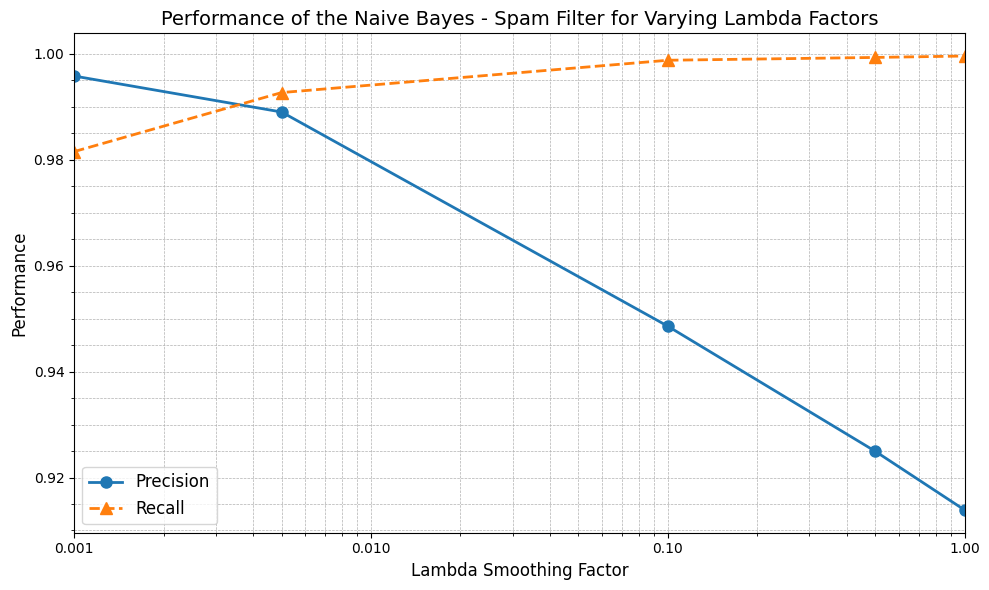

In [33]:
plt.figure(figsize=(10, 6))  # Bigger figure size

plt.plot(lambda_values, precision_values, label="Precision", linestyle='-', marker='o', linewidth=2, markersize=8)
plt.plot(lambda_values, recall_values, label="Recall", linestyle='--', marker='^', linewidth=2, markersize=8)

plt.title("Performance of the Naive Bayes - Spam Filter for Varying Lambda Factors", fontsize=14)
plt.xlabel("Lambda Smoothing Factor", fontsize=12)
plt.ylabel("Performance", fontsize=12)

plt.xscale("log")  # Logarithmic scale for x-axis

# Format x-ticks in decimal notation
def decimal_formatter(x, pos):
    return f'{x:.3f}' if x < 0.1 else f'{x:.2f}'
plt.gca().xaxis.set_major_formatter(FuncFormatter(decimal_formatter))

plt.xlim(min(lambda_values), max(lambda_values))  # Adjust x-axis limits

plt.grid(which='both', linestyle='--', linewidth=0.5)  # Adding grid
plt.minorticks_on()  # Enable minor ticks

plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()

**Answer**: Based on the paper by Hovold, a spam classifier model is preferred to have high precision and recall, but having a lower recall is acceptable as long as the precision is maximized. Therefore, the plot above indicates that a Laplace factor of 0.001 achieves the best balance between a high precision and a high recall. Since the precision trends downward at a faster rate than than the rate of increase in recall, the smoothing factor is ideally set as low as possible but not equal to zero as this tends to result in zero division, causing instability to the model. Moreover, the model recall seems to plateau at around 0.99 for a smoothing factor of 0.1. This implies that setting lambda higher than 0.1 is no longer reasonable for the model as there is only marginal improvement in recall while the precision decays at a sharp rate.

## Improving the Classifier

In [34]:
# Obtain the top 200 most informative words based on the mutual information of each word
# in relation to its label
vocabulary.calculate_word_probabilities()
vocabulary.calculate_mutual_information()

# Sort words by their MI score and select the top 200
vocabulary_top_200 = sorted(vocabulary.mi_scores, key=vocabulary.mi_scores.get, reverse=True)[:200]
print("Top 200 Most Informative Words from the Dataset")
word_count = 0
for word in vocabulary_top_200:
    print(f"{word_count + 1}. {word} {vocabulary.mi_scores[word]}")
    word_count += 1

Top 200 Most Informative Words from the Dataset
1. received 5.595711434838383
2. by 5.595711434838383
3. from 5.595155913440251
4. id 5.594169362728292
5. to 5.586504078871625
6. with 5.580969802546713
7. subject 5.563059517093572
8. for 5.235029565612196
9. edu 5.229249615487363
10. date 4.962940053096647
11. content 4.863986727028345
12. type 4.847497220911456
13. text 4.832046111331527
14. a 4.796903920608224
15. version 4.744190594922589
16. message 4.721160337250135
17. mime 4.604963873605781
18. esmtp 4.415737506385153
19. x 4.259906877403511
20. plain 4.245919205677499
21. charset 4.233169581484796
22. com 3.9494283289316936
23. transfer 3.8401074966855586
24. encoding 3.831878481413925
25. in 3.5016121665989868
26. b 3.4358117127010974
27. http 3.394976860670539
28. the 3.380088350602887
29. c 3.3342856568278636
30. is 3.2985482526067194
31. and 3.072540966992023
32. of 2.8817709901318516
33. i 2.8506665929762462
34. mailer 2.8358680601662165
35. bit 2.7884434564299316
36. this

In [35]:
# Rebuild the vocabulary with the top 200 most informative words
vocabulary.rebuild_vocabulary_with_top_words(vocabulary_top_200)

# Initialize and train the classifier
best_lambda = 0.001
classifier = NaiveBayesClassifier(lambda_value=best_lambda)
classifier.train(vocabulary)

# Evaluate the resulting performance of classifier with the reduced vocabulary
Y_pred = classifier.predict(vocabulary, X_test)
precision = get_precision(Y_pred, Y_test)
recall = get_recall(Y_pred, Y_test)
print(f"Precision of the Naive Bayes Classifier with Top 200 Vocabulary for λ = {best_lambda}: {precision}")
print(f"Recall of the Naive Bayes Classifier with Top 200 Vocabulary for λ = {best_lambda}: {recall}\n")

Precision of the Naive Bayes Classifier with Top 200 Vocabulary for λ = 0.001: 0.921254154023985
Recall of the Naive Bayes Classifier with Top 200 Vocabulary for λ = 0.001: 0.8460721868365181

